# **Preprocessing Audio files (Without Surprise Class)**

#  Importing


In [1]:
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from time import sleep, time
from sklearn.metrics import roc_curve, auc

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Datasets paths


In [4]:
# Data
Ravdess = "/content/drive/MyDrive/SER (Dataset)/RAVDESS/audio_speech_actors_01-24/"
Crema = "/content/drive/MyDrive/SER (Dataset)/CREMA/"
Savee = "/content/drive/MyDrive/SER (Dataset)/SAVEE/"


## <center>1. Ravdess Dataset</center>

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        #The third part of the name represents the emotion in the dialogue
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(10)
Ravdess_df.Emotions.value_counts()

Emotions
neutral     288
happy       192
angry       192
sad         192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64

## <center>2. Crema Dataset</center>

In [6]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
Crema_df.Emotions.value_counts()

Emotions
happy      1271
sad        1271
angry      1271
disgust    1271
fear       1271
neutral    1087
Name: count, dtype: int64

##  <center> 3. Savee dataset <center>

In [7]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
Savee_df.Emotions.value_counts()

Emotions
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64

# Data Integration <center>

In [8]:
data_path = pd.concat([Ravdess_df, Savee_df, Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()
data_path.Emotions.value_counts()

Emotions
happy       1523
angry       1523
sad         1523
fear        1523
disgust     1523
neutral     1495
surprise     252
Name: count, dtype: int64

In [9]:
data_path = data_path.drop(data_path[data_path['Emotions'] == 'surprise'].index)

In [10]:
data_path.Emotions.value_counts()

Emotions
sad        1484
angry      1482
fear       1476
neutral    1466
disgust    1463
happy      1459
Name: count, dtype: int64

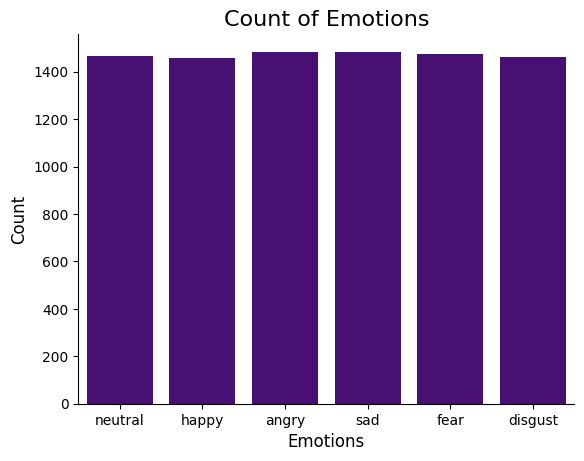

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = sns.color_palette(["#4B0082", "#8A2BE2", "#9932CC", "#BA55D3", "#DDA0DD", "#EE82EE"])
sns.set_palette(custom_palette)

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


Functions for:
* Waveplots
* Spectograms
* MFCC

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('The waveform for the sound in emotion {}'.format(e), size=10)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # Fourier.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {}'.format(e), size=10)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def create_mfcc(data,sr,e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12,3))
    plt.title('Mel-frequency cepstral coefficient for {}'.format(e), size=10)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

# Functions for extracting audio features:

In [13]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)
#RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
#MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [14]:
# example feature vectors extracted from the audio data
fname = Savee + 'DC_f11.wav'
data, sampling_rate = librosa.load(fname, duration=2.5, offset=0.6)
print("ZCR: ", zcr(data).shape)
print("RMS :", rmse(data).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (108,)
RMS : (108,)
MFCC:  (2160,)


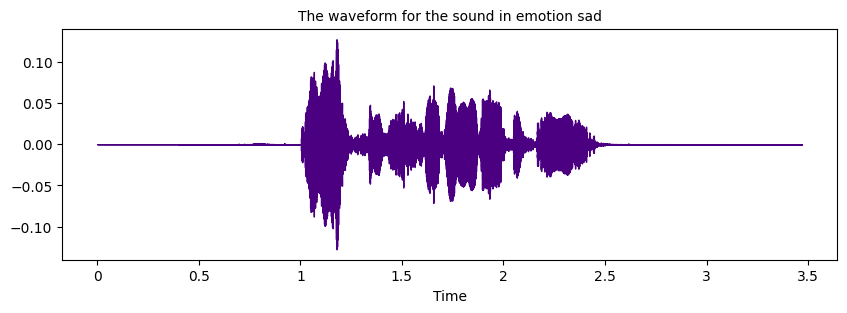

22050


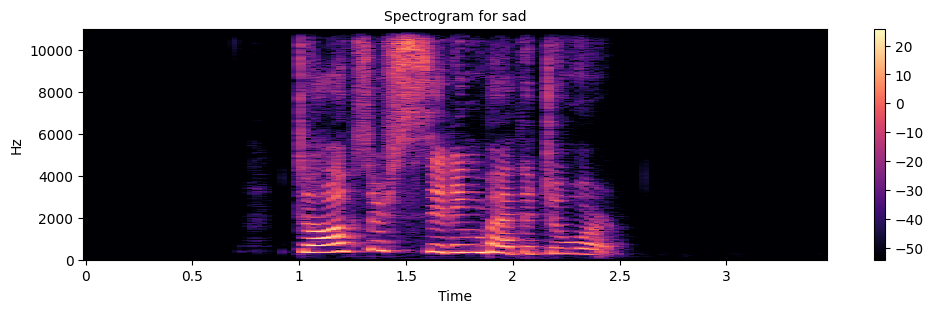

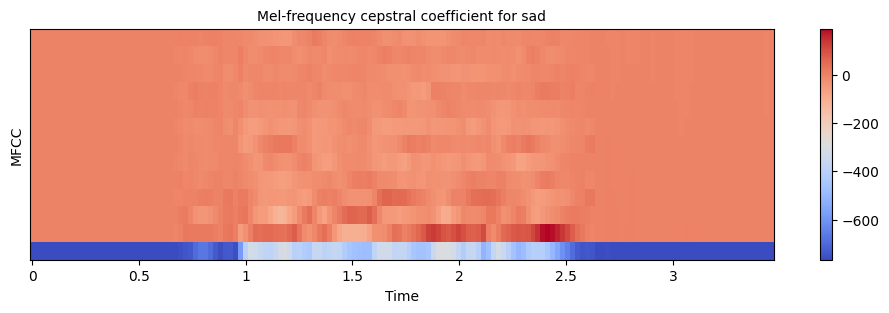

In [15]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data,sampling_rate,emotion)
Audio(path)

print(sampling_rate)

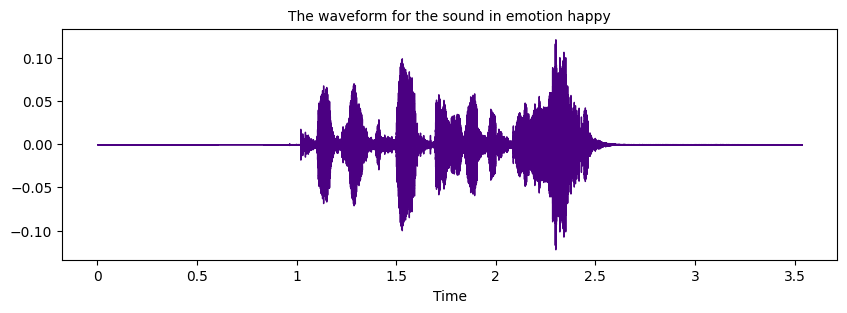

22050


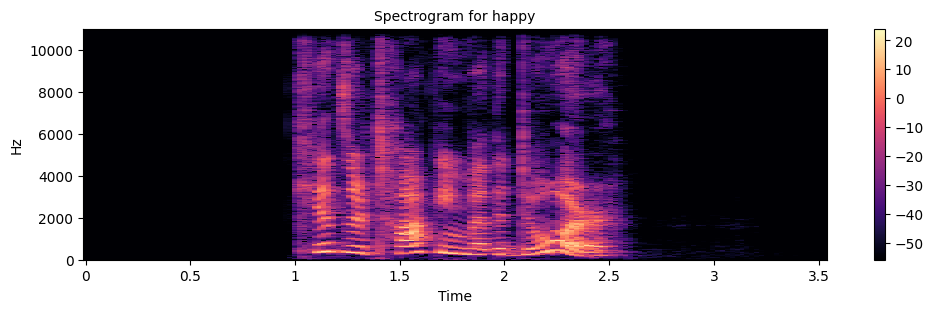

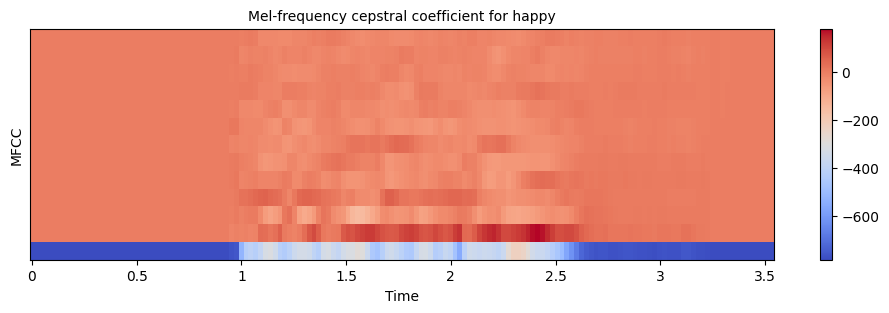

In [16]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data,sampling_rate,emotion)
Audio(path)
print(sampling_rate)

# Data Augmentation Functions for Audio Processing

In [17]:
# These functions are used to perform data augmentation on audio signals

def noise(data,noise_rate=0.015):
    noise_amp = noise_rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

path = np.array(data_path.Path)[2]
data, sample_rate = librosa.load(path)

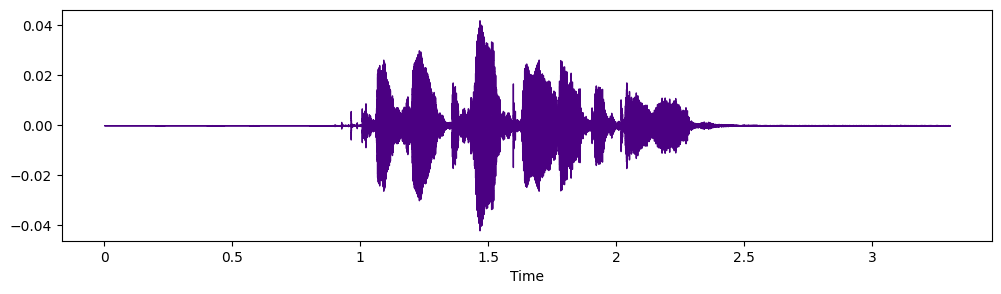

In [18]:
#Audio without augmentation
plt.figure(figsize=(12,3))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

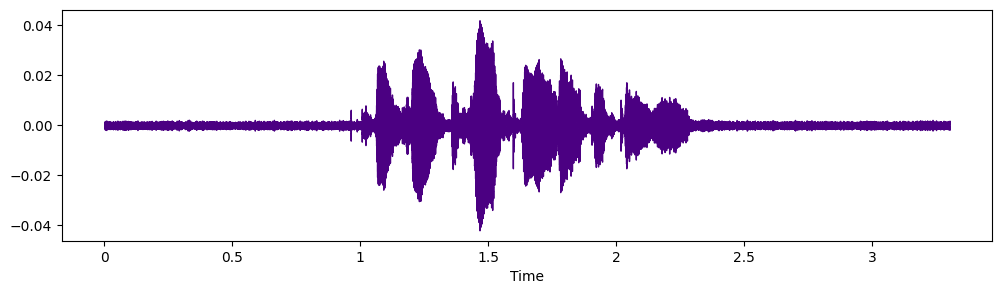

In [19]:
#Audio with noise added
x = noise(data)
plt.figure(figsize=(12,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### Shifting

22050

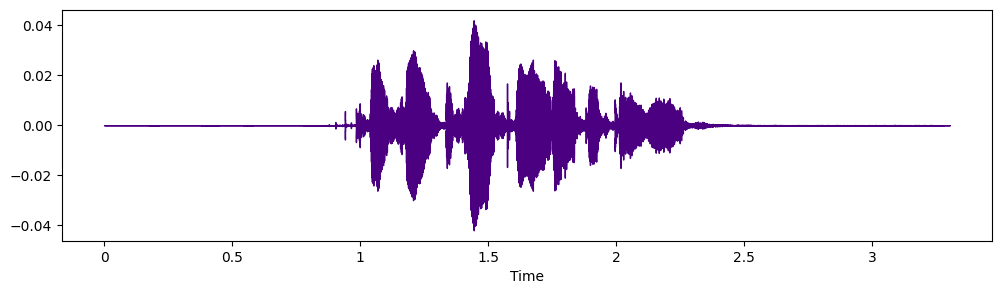

In [20]:
# Audio with shift added
x = shift(data)
plt.figure(figsize=(12,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)
sample_rate

In [21]:
hop_length = 512

In [22]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)
#RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
#MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [23]:
# Extract features and stack them into a one-dimensional matrix
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

#Utalizing GPU for Feature Extraction and Model Training


In [24]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print('GPU is available!')
else:
    print('GPU is not available.')

GPU is available!


In [25]:
# Define a tensor (replace this with your actual tensor creation)
tensor = torch.randn(3, 3)

# Move tensors/models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensor to GPU
tensor = tensor.to(device)

In [26]:
def get_features(path):
    #duration, offset
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data,sample_rate)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2))

    return result

### Features extraction by parallel processing:

In [27]:
from concurrent.futures import ThreadPoolExecutor

start_time = time()

# Appending emotion many times as we have made many augmentation techniques on each audio file.
def process_audio_file(path, emotion, X, Y):
  feature = get_features(path)
  for ele in feature:
      X.append(ele)
      Y.append(emotion)
  return (path, emotion)

if __name__ == "__main__":
    Q, R = [], []
    with ThreadPoolExecutor() as executor:
        f = []
        for path, emotion in zip(data_path.Path, data_path.Emotions):
            future = executor.submit(process_audio_file, path, emotion, Q, R)
            f.append(future)

        for future in f:
            path, emotion = future.result()


parallel_execution_time = time() - start_time

print("Execution Time (Parallel processing): ", parallel_execution_time)

Execution Time (Parallel processing):  583.7665174007416


In [28]:
len(Q), len(R), data_path.Path.shape

(17660, 17660, (8830,))

In [29]:
Features = pd.DataFrame(Q)
Features['labels'] = R
Features.to_csv('features(withoutSurpriseClass).csv', index=False)
Features.head(20)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.167969,0.167969,0.167969,0.004883,0.000000,0.000000,0.000000,0.008789,0.241211,0.373047,...,-12.609936,-2.088015,-4.638239,-8.565639,-1.704041,1.969467,-2.567831,-14.171959,6.574815,neutral
1,0.257812,0.380371,0.505859,0.505859,0.509766,0.511230,0.503906,0.494141,0.488281,0.497070,...,-5.640803,-5.834661,-0.892627,0.744489,3.423543,1.670861,-0.755905,-7.994479,-6.075125,neutral
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071777,0.080078,0.080078,0.080078,...,5.985907,3.102307,6.882236,10.619616,7.653634,5.451030,5.210598,6.949718,8.289808,neutral
3,0.259766,0.390625,0.512695,0.514160,0.512695,0.496582,0.506836,0.509277,0.508789,0.518555,...,6.405708,2.013273,4.863176,3.086186,2.890581,5.990909,9.031114,4.319618,0.966362,neutral
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008301,0.138672,0.138672,...,-1.257085,-0.928518,-1.008308,-1.333871,-1.670437,-1.808489,-1.636770,-1.168537,-0.518752,neutral
5,0.253418,0.381836,0.500000,0.485352,0.489746,0.486328,0.493164,0.499512,0.512207,0.503906,...,-2.414565,-1.871120,4.555675,5.557249,-2.546781,0.784063,4.721645,3.582229,3.338175,neutral
6,0.241699,0.367188,0.504395,0.478516,0.525879,0.518066,0.501465,0.469238,0.461426,0.477051,...,-7.295108,-4.029252,9.299551,12.841881,7.419745,4.341983,2.004731,2.757601,2.666529,neutral
7,0.231445,0.356934,0.482422,0.486328,0.500488,0.501953,0.499023,0.499023,0.500000,0.501953,...,2.095691,2.755023,8.126006,6.010901,5.026505,2.473329,-3.555655,-0.092842,2.188890,neutral
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.080078,0.241211,0.409668,0.611816,0.680176,...,0.155731,-0.443496,-1.186210,-1.758244,-1.894165,-1.604157,-1.208965,-1.126367,-1.564620,happy
9,0.251465,0.373047,0.495117,0.483398,0.490723,0.496094,0.493164,0.488281,0.489746,0.479004,...,4.124623,0.149266,5.457037,2.042920,0.060574,2.741642,-1.352297,-3.656105,-6.262865,happy


In [30]:
Features.tail()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
17655,0.054688,0.103516,0.138184,0.132324,0.116211,0.096680,0.078125,0.080078,0.068848,0.047363,...,0.250023,-6.966587,-4.605624,-1.448350,-3.979310,-7.176755,-3.539129,-1.591558,-4.712140,fear
17656,0.041504,0.054688,0.067383,0.057129,0.045410,0.039551,0.036133,0.034180,0.035156,0.057129,...,-6.494700,2.853506,-12.570461,-3.147230,-13.414394,1.362216,-6.407760,-0.898867,-6.384496,neutral
17657,0.047363,0.062500,0.077148,0.072754,0.063965,0.065430,0.070312,0.068359,0.061523,0.077637,...,-5.733693,-7.137160,-5.439306,-6.840502,-4.001735,-4.503624,-5.012168,-3.336011,-8.978669,neutral
17658,0.030273,0.042480,0.054199,0.044922,0.052246,0.055664,0.055176,0.052246,0.047852,0.044922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy
17659,0.031250,0.046387,0.061035,0.052734,0.059082,0.060547,0.056152,0.055176,0.051758,0.047852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy


# Model #2: LSTM

## Import required libraries:

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df = pd.read_csv('features(withoutSurpriseClass).csv')
print(df.shape)

(17660, 2377)


In [33]:
df = df.fillna(0)
print(df.isna().any())
df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(17660, 2377)

In [39]:
X = df.iloc[:, :-1].values
Y = df['labels'].values

## Encoding target column:

In [40]:
 #Encode labels into categorical numerical values
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(Y)  # Encode labels to integers
num_classes = len(label_encoder.classes_)

In [41]:
print(Y.shape)
print(X.shape)

(17660,)
(17660, 2376)


In [42]:
X

array([[  0.16796875,   0.16796875,   0.16796875, ...,  -2.56783128,
        -14.17195892,   6.5748148 ],
       [  0.2578125 ,   0.38037109,   0.50585938, ...,  -0.75590526,
         -7.99447902,  -6.07512483],
       [  0.        ,   0.        ,   0.        , ...,   5.21059752,
          6.94971752,   8.28980827],
       ...,
       [  0.04736328,   0.0625    ,   0.07714844, ...,  -5.01216755,
         -3.3360115 ,  -8.9786687 ],
       [  0.03027344,   0.04248047,   0.05419922, ...,   0.        ,
          0.        ,   0.        ],
       [  0.03125   ,   0.04638672,   0.06103516, ...,   0.        ,
          0.        ,   0.        ]])

## Normalize The input data:

In [43]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [44]:
X

array([[ 1.28127889,  0.58504654,  0.22865862, ..., -0.66105604,
        -5.07673043,  2.48111495],
       [ 2.41860738,  2.41366808,  2.45227752, ..., -0.08630846,
        -2.83354734, -2.02496545],
       [-0.8450309 , -0.86103578, -0.87672419, ...,  1.80628152,
         2.59302946,  3.09201893],
       ...,
       [-0.24546099, -0.32295864, -0.36901929, ..., -1.43640577,
        -1.14195209, -3.05924724],
       [-0.46180064, -0.49531147, -0.52004543, ...,  0.15346663,
         0.06942936,  0.13907657],
       [-0.44943838, -0.46168165, -0.47505892, ...,  0.15346663,
         0.06942936,  0.13907657]])

## Splitting data for training & testing:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build the LSTM Model:

In [46]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2376, 64)          16896     
                                                                 
 dropout (Dropout)           (None, 2376, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 50310 (196.52 KB)
Trainable params: 50310 (196.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compile the model:

In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the LSTM Model

In [49]:
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=200, batch_size=64, validation_split=0.1)

Epoch 1/200
199/199 [==============================] - 37s 156ms/step - loss: 1.7789 - accuracy: 0.2005 - val_loss: 1.7793 - val_accuracy: 0.1960
Epoch 2/200
199/199 [==============================] - 35s 174ms/step - loss: 1.7763 - accuracy: 0.2006 - val_loss: 1.7790 - val_accuracy: 0.1975
Epoch 3/200
199/199 [==============================] - 30s 151ms/step - loss: 1.7750 - accuracy: 0.2050 - val_loss: 1.7808 - val_accuracy: 0.1812
Epoch 4/200
199/199 [==============================] - 30s 150ms/step - loss: 1.7717 - accuracy: 0.2041 - val_loss: 1.7812 - val_accuracy: 0.2031
Epoch 5/200
199/199 [==============================] - 29s 148ms/step - loss: 1.7743 - accuracy: 0.2045 - val_loss: 1.7810 - val_accuracy: 0.1939
Epoch 6/200
199/199 [==============================] - 46s 233ms/step - loss: 1.7706 - accuracy: 0.2094 - val_loss: 1.7746 - val_accuracy: 0.1996
Epoch 7/200
199/199 [==============================] - 28s 141ms/step - loss: 1.7665 - accuracy: 0.2118 - val_loss: 1.7731 -

## Evaluate the Model

In [50]:
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

111/111 [==============================] - 7s 63ms/step - loss: 1.7637 - accuracy: 0.2146
Test Loss: 1.7637, Test Accuracy: 0.2146


## Visualize Model Performance

In [51]:
y_pred_prob = model.predict(np.expand_dims(X_test, axis=-1))
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert predicted probabilities to class labels
conf_matrix = confusion_matrix(y_test, y_pred)

111/111 [==============================] - 16s 113ms/step


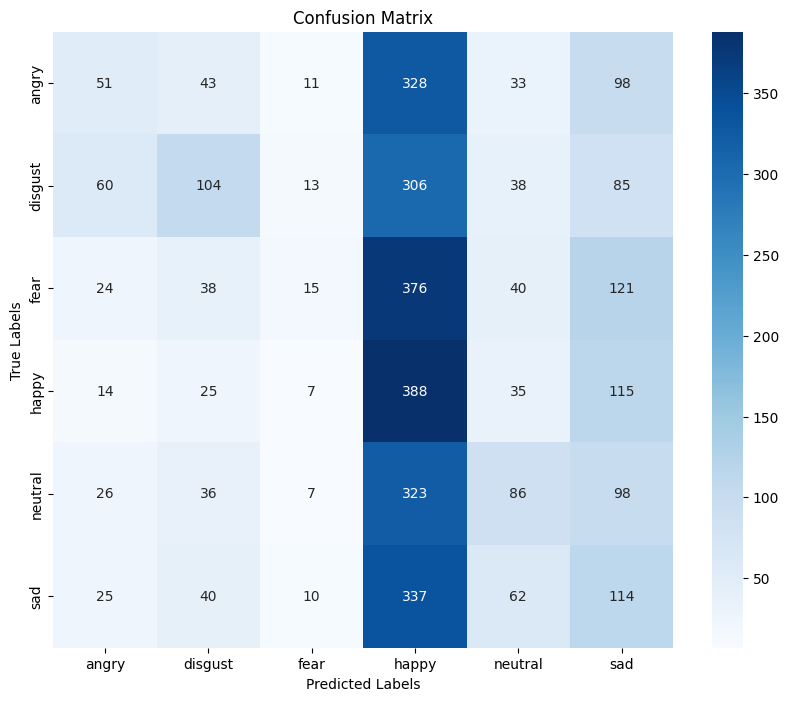

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [53]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

       angry       0.26      0.09      0.13       564
     disgust       0.36      0.17      0.23       606
        fear       0.24      0.02      0.04       614
       happy       0.19      0.66      0.29       584
     neutral       0.29      0.15      0.20       576
         sad       0.18      0.19      0.19       588

    accuracy                           0.21      3532
   macro avg       0.25      0.22      0.18      3532
weighted avg       0.25      0.21      0.18      3532

